## Background

Rainfall anomalies are deviations of annual rainfall from long-run averages. They are useful for identifying wet and dry years which can be linked to climatically influenced patterns such as agricultural production.

## Description
In this real world example we will calculate rainfall anomalies for a selected African country using the CHIRPS monthly rainfall dataset. The notebook outlines:

1. Loading a shapefile for African countries and selecting a single country
2. Loading and rainfall data and masking it to the selected country.
3. Calculating annual rainfall anomalies and plotting the result.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [ ]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import json
import matplotlib.pyplot as plt

from datacube.utils.geometry import Geometry, CRS
from deafrica_tools.spatial import xr_rasterize

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [ ]:
create_local_dask_cluster()

### Analysis parameters

The following cell sets important parameters for the analysis:

* `country`: In this analysis, we'll select an African country to mask the dataset and analysis.
* `geopolygon`: Based on the selected country, we'll use a geopolygon to bound our data loading call.
* `time_range`: CHIRPS monthly rainfall is available from 1981, so we'll use the entire epoch available.
* `output_crs`: Both CHIRPS monthly rainfall and the country polygons are projected naturally in epsg:4326 in degree units. We'll load the data in epsg:6933 but we'll have to be careful to make sure crs is aligned as we proceed.
* `resolution`: We'll use 5,000 m, which is approximately equal to the default resolution shown above.
* `measurements`: Rainfall.
* `dask_chunks`:  the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.


In [ ]:
# Select a country, for the example we will use Zimbabwe, a complete list of countries is available below.
country = "Zimbabwe"

# Set the range of dates for the climatology
time_range = ('1999', '2019')

# year and month for anomaly
year = '2021'
month = 'July'

# some final specifications
resolution = (-5000, 5000)
measurements = ['rainfall']
dask_chunks = dict(x=1000,y=1000)

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='rainfall_anomaly')

### Load the African Countries shapefile

This shapefile contains polygons for the boundaries of African countries and will allows us to calculate rainfall anomalies within a chosen country

In [ ]:
african_countries = gpd.read_file('../Supplementary_data/Rainfall_anomaly_CHIRPS/african_countries.shp')
african_countries.explore()

### Select a country

You can change the argument below to any African country, we'll use Zimbabwe for this example. A complete list of countries is printed below.

In [4]:
print(np.unique(african_countries.COUNTRY))

['Algeria' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Cape Verde' 'Central African Republic' 'Chad' 'Comoros'
 'Congo-Brazzaville' 'Cote d`Ivoire' 'Democratic Republic of Congo'
 'Djibouti' 'Egypt' 'Equatorial Guinea' 'Eritrea' 'Ethiopia' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Kenya' 'Lesotho' 'Liberia'
 'Libya' 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Morocco' 'Mozambique'
 'Namibia' 'Niger' 'Nigeria' 'Rwanda' 'Sao Tome and Principe' 'Senegal'
 'Sierra Leone' 'Somalia' 'South Africa' 'Sudan' 'Swaziland' 'Tanzania'
 'Togo' 'Tunisia' 'Uganda' 'Western Sahara' 'Zambia' 'Zimbabwe']


In [5]:
country = "Zimbabwe"

## Setup polygon

The country selected needs to be transformed into a geometry object to be used in the `dc.load()` function.

In [6]:
idx = african_countries[african_countries['COUNTRY'] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

## Load rainfall data

First, let's have a look at the product information for CHIRPS rainfall. 

In [7]:
dc.list_products().loc[dc.list_products()['name'].str.contains('chirps')]

,name,description,license,default_crs,default_resolution
name,,,,,
rainfall_chirps_monthly,rainfall_chirps_monthly,Rainfall Estimates from Rain Gauge and Satelli...,None,EPSG:4326,"(-0.05000000074505806, 0.05000000074505806)"


### Analysis parameters

* `geopolygon`: In this analysis, we'll use a geopolygon (country) to bound our data loading call.
* `time`: CHIRPS monthly rainfall is available from 1981, so we'll use the entire epoch available.
* `output_crs`: Both CHIRPS monthly rainfall and the country polygons are projected naturally in epsg:4326 in degree units. We'll load the data in epsg:6933 but we'll have to be careful to make sure crs is aligned as we proceed.
* `resolution`: We'll use 5,000 m, which is approximately equal to the default resolution shown above.
* `measurements`: Rainfall.



In [8]:
query = {'geopolygon': geom,
         'time': time_range,
         'output_crs': 'epsg:6933',
         'resolution': resolution,
         'measurements': measurements,
         'dask_chunks':dask_chunks
        }

ds_rf = dc.load(product='rainfall_chirps_monthly', **query)
ds_rf

<xarray.Dataset>
Dimensions:      (time: 480, y: 165, x: 151)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-16T11:59:59.500000 ... 2020-12...
  * y            (y) float64 -1.968e+06 -1.972e+06 ... -2.782e+06 -2.788e+06
  * x            (x) float64 2.438e+06 2.442e+06 ... 3.182e+06 3.188e+06
    spatial_ref  int32 6933
Data variables:
    rainfall     (time, y, x) float32 231.3 230.4 230.4 ... 209.4 210.9 198.6
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Make a mask for country boundary

Below, the country polygon is rasterized so the rainfall dataset is masked within that raster.

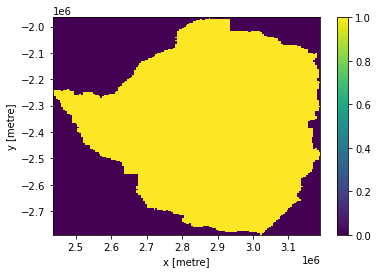

In [10]:
african_countries = african_countries.to_crs('epsg:6933')

mask = xr_rasterize(african_countries[african_countries['COUNTRY'] == country], ds_rf)

# Plot the mask
mask.plot()

## Total annual rainfall averaged across a country

We want to capture the annual total (sum of months) and spatial mean of rainfall within the country polygon for each year from 1981 to 2020. Firstly, rainfall is summed to an annual total and the result for 1981 is plotted. 

In the subsequent cell, a spatial mean is calculated.

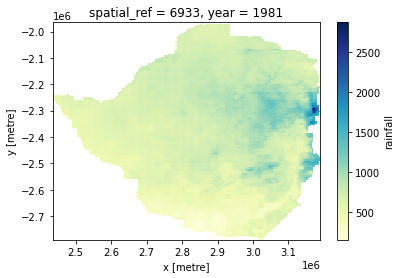

In [11]:
ds_rf = ds_rf.where(ds_rf !=-9999.) #convert missing values to NaN

ds_rf_annual = ds_rf.groupby('time.year').sum('time').where(mask) # group by year and mask to country

# Look at rainfall in the first year, 1981
ds_rf_annual['rainfall'].sel(year=1981).plot(cmap='YlGnBu', label=False);

In [12]:
#find the spatial mean
ds_rf_annual_mean = ds_rf_annual.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
ds_rf_annual_mean.head()

,rainfall
year,
1981,706.703796
1982,466.900269
1983,471.532043
1984,556.608459
1985,753.728760


## Calculate standardised rainfall anomaly for each year

Here, we calculate the standardised rainfall anomaly for each year in the dataset. This is the anomaly (rainfall in a given year relative to mean rainfall over the epoch), standardised relatived to the standard deviation calculated across the epoch.

In [13]:
ds_rf_annual_mean["anomaly"] = (ds_rf_annual_mean.rainfall - ds_rf_annual_mean.rainfall.mean())/ds_rf_annual_mean.rainfall.std()
ds_rf_annual_mean.head()

,rainfall,anomaly
year,,
1981,706.703796,0.583454
1982,466.900269,-1.344823
1983,471.532043,-1.307578
1984,556.608459,-0.623473
1985,753.728760,0.961585


### Plot the result

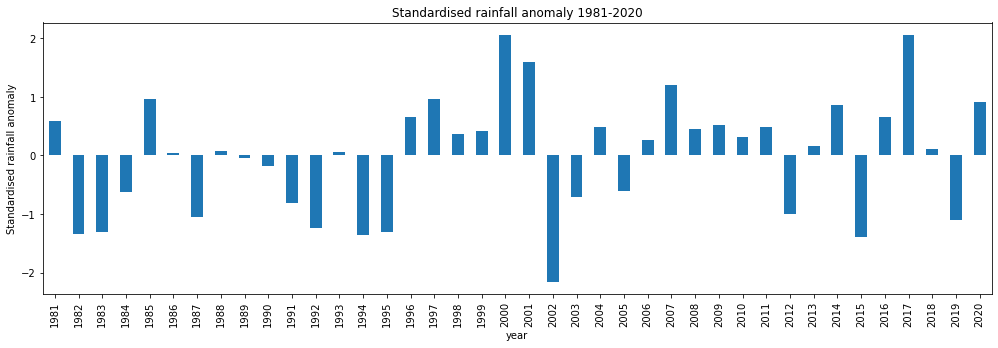

In [14]:
ds_rf_annual_mean.anomaly.plot.bar(figsize=(17,5))
plt.title('Standardised rainfall anomaly 1981-2020')
plt.ylabel('Standardised rainfall anomaly');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')